# Budowanie modeli na przetworzonym zbiorze "Chess king rook"
Julia Kaznowska, Piotr Wilczyński <br>
Politechnika Warszawska, Wydział Matematyki i Nauk Informacyjnych, Wstęp do uczenia maszynowego

## Import niezbędnych bibliotek oraz zbioru danych

In [60]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

# zbiory danych
df_train = pd.read_csv("train_processed_data.csv", index_col = 0)
df_test = pd.read_csv("test_processed_data.csv", index_col = 0)

# wyświetlanie wizualizacji
%matplotlib inline

## Przygotowanie danych

In [61]:
X_train = df_train.drop('result', axis = 1)
y_train = df_train.result
X_test = df_test.drop('result', axis = 1)
y_test = df_test.result

## Random Forest  i wybranie najważniejszych cech

Użyjemy modelu opartego o las losowy, aby stwierdzić, czy któraś z naszych zmiennych nie pogarsza predykcyjności. Problemem będzie to, że nie jest oczywiste, w jaki sposób oceniać jak dobre są predykcje. Wiemy przecież, że jeśli wynikiem powinien być mat w 14 ruchach, to lepiej będzie, żeby model przewidział odpowiedź 13 niż 2. Zatem nie możemy używać takiej miary jak 'accuracy' albo 'recall'. Kusi, żeby w takim przypadku użyć RMSE, żeby wiedzieć jak daleko jesteśmy od poprawnych wyników. Tu jednak natrafiamy na problem z remisami. Jeśli nasz model przewidzi mat w 3 ruchach, gdy powinien być remis, to nie będzie to lepszy wynik niż jeśli model przewidzi mat w 15 ruchach. Napiszemy zatem 2 funkcje oceniające czy predykcje są dobre.

#### Remisy

Funkcja będzie liczyć F1-score dla rekordów, w których pojawiają się remisy.

In [62]:
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score

def draw_f1_fun(X, y):
    X = np.array(X.copy())
    y = y.copy()
    for i in range(0, len(y)):
        if (y[i] != -1):
            y[i] = 0
        else: y[i] = 1
        if (X[i] != -1):
            X[i] = 0
        else: X[i] = 1
    return f1_score(y, X, zero_division = 0)

draw_f1 = make_scorer(draw_f1_fun, greater_is_better=True)

#### Wygrane

Funkcja będzie liczyć rmse dla rekordów w których biały wygrywa.

In [63]:
def win_neg_rmse_fun(X, y):
    X = np.array(X.copy())
    y = y.copy()
    mse = 0
    cnt = 0
    for i in range(0, len(y)):
        if(y[i] != -1 and X[i] != -1):
            mse += (X[i] - y[i])**2
            cnt += 1
    return -1*np.sqrt(mse/cnt)

win_neg_rmse = make_scorer(win_neg_rmse_fun, greater_is_better=True)

### Najważniejsze cechy

In [64]:
from sklearn.ensemble import RandomForestClassifier

In [65]:
rf_clas = RandomForestClassifier(random_state = 1)
rf_clas.fit(X_train, y_train)
feature_importances = rf_clas.feature_importances_
feature_importances

array([0.08117867, 0.07319905, 0.07035494, 0.01310361, 0.01376083,
       0.01510782, 0.11492081, 0.10913591, 0.11528465, 0.10174292,
       0.15520613, 0.13700464])

In [66]:
sorted(zip(feature_importances, X_train.columns), reverse=True)

[(0.1552061335458736, 'wrook_bking_dist_x'),
 (0.13700464349992103, 'wrook_bking_dist_y'),
 (0.11528464630662748, 'wking_bking_dist_x'),
 (0.11492080840035473, 'wking_wrook_dist_x'),
 (0.10913591305067713, 'wking_wrook_dist_y'),
 (0.10174292108743456, 'wking_bking_dist_y'),
 (0.0811786735046134, 'white_king_edge_dist'),
 (0.07319905431196676, 'white_rook_edge_dist'),
 (0.07035494216330455, 'black_king_edge_dist'),
 (0.01510782208949005, 'black_king_in_corner'),
 (0.013760832060520626, 'white_rook_in_corner'),
 (0.013103609979216115, 'white_king_in_corner')]

Jak widać najmniejszy wpływ na predykcyjność mają kolumny mówiące o tym, czy dana figura jest w rogu. Największy ma odległość wieży od czarnego króla.

Napiszemy niestandardowy transformator, którego użyjemy, aby sprawdzić, czy modele uczone na danych bez najmniej istotnych kolumn będą osiągały lepsze wyniki.

In [67]:
from sklearn.base import BaseEstimator, TransformerMixin

class SelectBestFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importances, k):
        self.feature_importances = feature_importances
        self.k = k
    def fit(self, X, y=None):
        self.feature_indices_ = np.sort(np.argpartition(np.array(self.feature_importances), -self.k)[-self.k:])
        return self
    def transform(self, X):
        return X.iloc[:, self.feature_indices_]

In [68]:
k = None
rf_kfeatures_pipeline = Pipeline([
    ('feature_selection', SelectBestFeatures(feature_importances, k)),
    ('rf_clas', RandomForestClassifier(random_state = 1))
])

Sprawdźmy czy pozbywając się najmniej istotnych kolumn poprawimy predykcyjność.

#### Remisy

In [10]:
params = [{'feature_selection__k': list(range(1, len(feature_importances) + 1))}]

In [11]:
grid_search_draws_k = GridSearchCV(rf_kfeatures_pipeline,
                                params, cv = 5,
                                scoring = draw_f1)

grid_search_draws_k.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectBestFeatures(feature_importances=array([0.08117867, 0.07319905, 0.07035494, 0.01310361, 0.01376083,
       0.01510782, 0.11492081, 0.10913591, 0.11528465, 0.10174292,
       0.15520613, 0.13700464]),
                                                           k=None)),
                                       ('rf_clas',
                                        RandomForestClassifier(random_state=1))]),
             param_grid=[{'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12]}],
             scoring=make_scorer(draw_f1_fun))

In [12]:
grid_search_draws_k.cv_results_["mean_test_score"]

array([0.45875085, 0.97055218, 0.97055218, 0.97055218, 0.99703612,
       0.99821604, 0.99585618, 0.99409325, 0.99413088, 0.99468649,
       0.9912085 , 0.99117445])

In [13]:
grid_search_draws_k.best_params_

{'feature_selection__k': 6}

Najwyższą predykcyjność dostaliśmy używając tylko 6 najważniejszych kolumn, a więc tych informujących o odległości figur między sobą. Jest to zgodne z intuicją, ponieważ aby był remis czarny król musi zbić wieżę w najbliższym ruchu (a więc stać obok niej). Reszta kolumn jest w tym przypadku szumem.

#### Wygrane

In [14]:
grid_search_wins_k = GridSearchCV(rf_kfeatures_pipeline,
                                params, cv = 5,
                                scoring = win_neg_rmse)

grid_search_wins_k.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('feature_selection',
                                        SelectBestFeatures(feature_importances=array([0.08117867, 0.07319905, 0.07035494, 0.01310361, 0.01376083,
       0.01510782, 0.11492081, 0.10913591, 0.11528465, 0.10174292,
       0.15520613, 0.13700464]),
                                                           k=None)),
                                       ('rf_clas',
                                        RandomForestClassifier(random_state=1))]),
             param_grid=[{'feature_selection__k': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10, 11, 12]}],
             scoring=make_scorer(win_neg_rmse_fun))

In [15]:
-grid_search_wins_k.cv_results_["mean_test_score"]

array([3.56840105, 3.39045265, 3.41516914, 3.27815191, 3.16592688,
       2.94505793, 2.40477893, 2.22746555, 1.60686565, 1.43823053,
       1.44199046, 1.44483129])

In [16]:
grid_search_wins_k.best_params_

{'feature_selection__k': 10}

Nasz model najlepiej przybliża liczbę ruchów do mata używając 10 najważniejszych kolumn. Okazuje się, że informacja o tym czy wieża i biały król są w rogach szachownicy jest dla nas nieistotna.

In [17]:
y_train.loc[np.where(y_train == - 1)].size/y_train.size

0.09967922062492575

Mniej niż 10% rekordów w naszym zbiorze opisuje remisy. Z tego powodu ważniejsze wydaje się być dobre przybliżenie liczby ruchów do mata. Zostawimy zatem 10 najważniejszych kolumn.

In [69]:
X_train = X_train.drop(['white_rook_in_corner', 'white_king_in_corner'], axis = 1)
X_test = X_test.drop(['white_rook_in_corner', 'white_king_in_corner'], axis = 1)

## Wybór modelu

Wybierzmy 3 najbardziej obiecujące modele na domyślnych parametrach. Do standardowych modeli dodamy StackingClassifier, który będzie wykorzystywał wszystkie pozostałe jako modele bazowe. Jako meta-model, będzie wykorzystywał regresję logistyczną.

In [70]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score

In [71]:
base_models = list([
    ('lr', LogisticRegression()),
    ('dtc', DecisionTreeClassifier(random_state = 1)),
    ('knn', KNeighborsClassifier()),
    ('rfc', RandomForestClassifier(random_state = 1)),
    ('ab', AdaBoostClassifier(random_state = 1)),
    ('gb', GradientBoostingClassifier(random_state = 1)),
    ('xgb', XGBClassifier(random_state = 1, booster = 'gbtree', verbosity = 0)),
    ('svm', SVC()),
    ('bayes', GaussianNB())
])

In [72]:
models = dict()
models['lr'] = LogisticRegression()
models['dtc'] = DecisionTreeClassifier(random_state = 1)
models['knn'] = KNeighborsClassifier()
models['rfc'] = RandomForestClassifier(random_state = 1)
models['ab'] = AdaBoostClassifier(random_state = 1)
models['gb'] = GradientBoostingClassifier(random_state = 1)
models['xgb'] = XGBClassifier(random_state = 1, booster = 'gbtree', verbosity = 0)
models['svm'] = SVC()
models['bayes'] = GaussianNB()
models['stacking'] = StackingClassifier(estimators = base_models, final_estimator = LogisticRegression(), cv=5)

Będziemy oceniali modele używając walidacji krzyżowej i wcześniej napisanych scoringów.

In [73]:
def cross_evaluate_draw(model, X, y):   
    cross_val = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state = 1)
    scores = cross_val_score(model, X, y, scoring = draw_f1, cv = cross_val, n_jobs = -1, error_score = 'raise')
    return scores

In [74]:
def cross_evaluate_win(model, X, y):   
    cross_val = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 3, random_state=1)
    scores = cross_val_score(model, X, y, scoring = win_neg_rmse, cv = cross_val, n_jobs = -1, error_score = 'raise')
    return scores

#### Remisy

In [150]:
draw_results = []
model_names = []
for name, model in models.items():
    scores = cross_evaluate_draw(model, X_train, y_train)
    draw_results.append(scores)
    model_names.append(name)
    print(f"{name}: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

lr: mean = 0.7707, std = 0.0255
dtc: mean = 0.9988, std = 0.0028
knn: mean = 0.8429, std = 0.0223
rfc: mean = 0.9961, std = 0.0047
ab: mean = 0.3367, std = 0.0933
gb: mean = 0.9974, std = 0.0039
xgb: mean = 0.9994, std = 0.0018
svm: mean = 0.8278, std = 0.0193
bayes: mean = 0.5006, std = 0.0693
stacking: mean = 0.9918, std = 0.0076


Modele dające najlepsze wyniki: DecisionTreeClassifier, RandomForestClassifier, GradientBoostingClassifier, XGBClassifier, StackingClassifier

Sprawdźmy wydajność na danych testowych.

In [24]:
draw_results_test = []
for name, model in models.items():
    model.fit(X_train, y_train)
    scores = draw_f1_fun(y_test, model.predict(X_test))
    draw_results_test.append(scores)
    print(f"{name}: mean = {np.round(np.mean(scores), 4)}")

lr: mean = 0.7785
dtc: mean = 0.9977
knn: mean = 0.8517
rfc: mean = 0.9931
ab: mean = 0.2744
gb: mean = 0.9977
xgb: mean = 0.998
svm: mean = 0.8422
bayes: mean = 0.4876
stacking: mean = 0.9896


Wyniki na danych testowych nie różnią się znacząco.

#### Wygrane

In [151]:
win_results = []
for name, model in models.items():
    scores = cross_evaluate_win(model, X_train, y_train)
    win_results.append(scores)
    print(f"{name}: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

lr: mean = -1.8415, std = 0.077
dtc: mean = -1.5301, std = 0.0746
knn: mean = -1.8103, std = 0.1069
rfc: mean = -1.4194, std = 0.074
ab: mean = -2.7558, std = 0.1092
gb: mean = -1.5688, std = 0.072
xgb: mean = -1.325, std = 0.0532
svm: mean = -1.6669, std = 0.0743
bayes: mean = -4.1382, std = 0.1008
stacking: mean = -1.4881, std = 0.0775


In [25]:
win_results_test = []
for name, model in models.items():
    model.fit(X_train, y_train)
    scores = win_neg_rmse_fun(y_test, model.predict(X_test))
    win_results_test.append(scores)
    print(f"{name}: mean = {np.round(np.mean(scores), 4)}")

lr: mean = -1.8308
dtc: mean = -1.4937
knn: mean = -1.827
rfc: mean = -1.3691
ab: mean = -2.6764
gb: mean = -1.5353
xgb: mean = -1.2662
svm: mean = -1.6207
bayes: mean = -4.1693
stacking: mean = -1.4264


Na danych testowych otrzymujemy bardzo zbliżoną wydajność

Najlepiej pod każdym względem poradził sobie xgboost, ma i najmniejsze średnie RMSE i najmniejsze odchylenie standardowe.

Modele dające najlepsze wyniki: DecisionTreeClassifier, RandomForestClassifier, XGBClassifier, StackingClassifier. A więc te same, które dawały dobre wyniki przy klasyfikacji remisów.

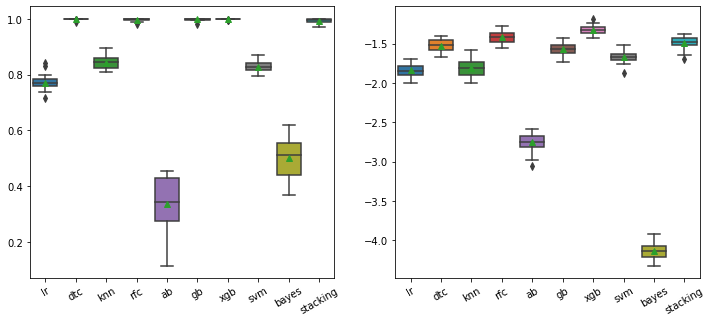

In [26]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))
sns.boxplot(data = draw_results, showmeans = True, ax = axes[0])
axes[0].set_xticklabels(model_names, rotation = 30)
sns.boxplot(data = win_results, showmeans = True, ax = axes[1])
axes[1].set_xticklabels(model_names, rotation = 30)
plt.show()

In [35]:
draw_results_test

[0.7784594410361282,
 0.9977023232065356,
 0.8517127071823204,
 0.9931280223975566,
 0.27436984162391254,
 0.9976964422830817,
 0.9979518689196109,
 0.8421507233858777,
 0.48758799555390886,
 0.9895859791719583]

In [48]:
-1 * np.array(win_results_test) 

array([1.83075413, 1.49372604, 1.82697353, 1.36911255, 2.67639387,
       1.53532394, 1.26615787, 1.62073558, 4.16933316, 1.42636049])

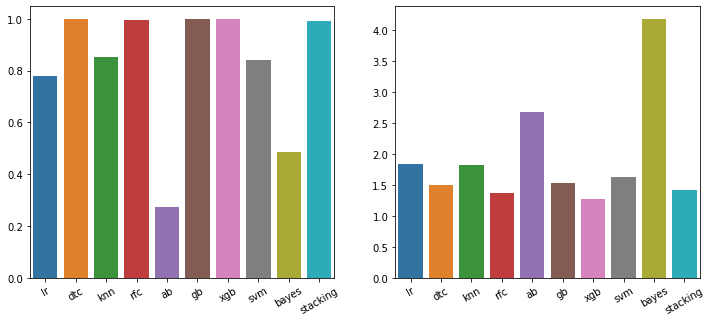

In [49]:
fig, axes = plt.subplots(1, 2, figsize = (12,5))
sns.barplot(y = draw_results_test, x = model_names, ax = axes[0])
axes[0].set_xticklabels(model_names, rotation = 30)
sns.barplot(y = -1 * np.array(win_results_test), x = model_names, ax = axes[1])
axes[1].set_xticklabels(model_names, rotation = 30)
plt.show()

Sprawdźmy jeszcze, czy lepiej nie poradzi sobie Stacking Classifier, który będzie używał tylko najlepszych modeli jako modeli bazowych.

In [75]:
selected_base_models = list([
    ('dtc', DecisionTreeClassifier(random_state = 1)),
    ('rfc', RandomForestClassifier(random_state = 1)),
    ('gb', GradientBoostingClassifier(random_state = 1)),
    ('xgb', XGBClassifier(random_state = 1, booster = 'gbtree', verbosity = 0)),
])
selected_stacking = StackingClassifier(estimators = selected_base_models,
                                       final_estimator = LogisticRegression(),
                                       cv = 5)

In [28]:
scores = cross_evaluate_draw(selected_stacking, X_train, y_train)
print(f"Stacking selected (draw): mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

Stacking selected (draw): mean = 0.9992, std = 0.002


In [66]:
scores = cross_evaluate_win(selected_stacking, X_train, y_train)
print(f"Stacking selected (win): mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

Stacking selected (win): mean = -1.2636, std = 0.0606


Wyliczanie modelu opartego o 'stacking' zajmuje dużo czasu. W ten sposób jednak udało nam się w najlepszy sposób estymować liczbę optymalnych ruchów potrzebnych do mata. W następnym kroku spróbujemy dobrać optymalne parametry do 3 najlepszych modeli podstawowych (bez 'stacking') i sprawdzić, który z nich jest najlepszy. Następnie zbudujemy na nich model 'StackingClassifier'. Ostatecznie wybierzemy najlepiej radzący sobie model.

Najlepiej radzące sobie modele: XGBClassifier, DecisionTreeClassifier, RandomForestClassifier.

### XGBClassifier

#### Optymalizacja ze względu na remisy

In [68]:
from sklearn.model_selection import RandomizedSearchCV
parameters = {
 "learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth" : [2, 4, 6, 8, 10, 12],
 "min_child_weight" : [1, 3, 5, 7],
 "gamma": [0.0, 0.1, 0.2 , 0.3, 0.4, 0.5],
 "colsample_bytree" : [0.2, 0.4, 0.6 , 0.8]
}
xgb = XGBClassifier(random_state=1, booster='gbtree', verbosity = 0)
xgb_params_search = RandomizedSearchCV(xgb, parameters, cv = 5, n_jobs = -1, n_iter = 50, scoring = draw_f1,
                                       random_state = 1)
xgb_params_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constra...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [69]:
xgb_params_search.best_params_

{'min_child_weight': 3,
 'max_depth': 12,
 'learning_rate': 0.25,
 'gamma': 0.2,
 'colsample_bytree': 0.8}

In [70]:
scores = cross_evaluate_draw(xgb_params_search.best_estimator_, X_train, y_train)
print(f"xgb: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

xgb: mean = 0.9994, std = 0.0018


In [71]:
scores = cross_evaluate_win(xgb_params_search.best_estimator_, X_train, y_train)
print(f"xgb: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

xgb: mean = -1.3287, std = 0.062


#### Optymalizacja ze względu na wygrane

In [72]:
parameters = {
 "learning_rate" : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth" : [2, 4, 6, 8, 10, 12],
 "min_child_weight" : [1, 3, 5, 7],
 "gamma": [0.0, 0.1, 0.2 , 0.3, 0.4, 0.5],
 "colsample_bytree" : [0.2, 0.4, 0.6 , 0.8]
}
xgb = XGBClassifier(random_state = 1, booster = 'gbtree', verbosity = 0)
xgb_params_search = RandomizedSearchCV(xgb, parameters, cv = 5, n_jobs = -1, n_iter = 50, scoring = win_neg_rmse,
                                       random_state = 1)
xgb_params_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster='gbtree',
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           enable_categorical=False, gamma=None,
                                           gpu_id=None, importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None,
                                           max_delta_step=None, max_depth=None,
                                           min_child_weight=None, missing=nan,
                                           monotone_constra...
                                           scale_pos_weight=None,
                                           subsample=None, tree_method=None,
                                      

In [73]:
xgb_params_search.best_params_

{'min_child_weight': 3,
 'max_depth': 12,
 'learning_rate': 0.2,
 'gamma': 0.3,
 'colsample_bytree': 0.8}

In [74]:
scores = cross_evaluate_win(xgb_params_search.best_estimator_, X_train, y_train)
print(f"xgb: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

xgb: mean = -1.3371, std = 0.056


In [75]:
scores = cross_evaluate_draw(xgb_params_search.best_estimator_, X_train, y_train)
print(f"xgb: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

xgb: mean = 0.9994, std = 0.0018


#### Wnioski

Ani szukając optymalnych parametrów dla remisów ani dla wygranych nie znaleźliśmy lepszego modelu niż ten z domyślnymi parametrami. Najlepszą predykcję zarówno remisów jak i opytmalnej liczby ruchów do mata otrzymujemy używając domyślnych parametrów.

### DecisionTreeClassifier

#### Optymalizacja ze względu na remisy

In [76]:
parameters = {
    "max_depth": [2, 4, 6, 8, 10, 12],
    "max_features": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}
dtc = DecisionTreeClassifier(random_state = 1)
dtc_params_search = RandomizedSearchCV(dtc, parameters, cv = 5, n_jobs = -1, n_iter = 50, scoring = draw_f1,
                                       random_state = 1)
dtc_params_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 6, 8, 10, 12],
                                        'max_features': [2, 4, 6, 8, 10],
                                        'min_samples_leaf': [1, 2, 4]},
                   random_state=1, scoring=make_scorer(draw_f1_fun))

In [77]:
dtc_params_search.best_params_

{'min_samples_leaf': 1, 'max_features': 8, 'max_depth': 8, 'criterion': 'gini'}

In [78]:
scores = cross_evaluate_draw(dtc_params_search.best_estimator_, X_train, y_train)
print(f"dtc: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

dtc: mean = 0.9984, std = 0.0031


In [79]:
scores = cross_evaluate_win(dtc_params_search.best_estimator_, X_train, y_train)
print(f"dtc: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

dtc: mean = -1.8196, std = 0.0897


#### Optymalizacja ze względu na wygrane

In [80]:
parameters = {
    "max_depth": [2, 4, 6, 8, 10, 12],
    "max_features": [2, 4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 4],
    "criterion": ["gini", "entropy"]
}
dtc = DecisionTreeClassifier(random_state = 1)
dtc_params_search = RandomizedSearchCV(dtc, parameters, cv = 5, n_jobs = -1, n_iter = 50, scoring = win_neg_rmse,
                                       random_state = 1)
dtc_params_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 4, 6, 8, 10, 12],
                                        'max_features': [2, 4, 6, 8, 10],
                                        'min_samples_leaf': [1, 2, 4]},
                   random_state=1, scoring=make_scorer(win_neg_rmse_fun))

In [81]:
dtc_params_search.best_params_

{'min_samples_leaf': 1,
 'max_features': 8,
 'max_depth': 12,
 'criterion': 'entropy'}

In [82]:
scores = cross_evaluate_win(dtc_params_search.best_estimator_, X_train, y_train)
print(f"dtc: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

dtc: mean = -1.5621, std = 0.0817


In [83]:
scores = cross_evaluate_draw(dtc_params_search.best_estimator_, X_train, y_train)
print(f"dtc: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

dtc: mean = 0.9964, std = 0.0053


#### Wnioski

Ponownie nie znaleźliśmy parametrów, które miałyby lepsze wyniki niż domyślne. Zarówno do klasyfikacji remisów jak i estymacji opytmalnej liczby ruchów do mata najbardziej opłaca się użyć domyślnych parametrów.

### RandomForestClassifier

#### Optymalizacja ze względu na remisy

In [84]:
parameters = {
    'n_estimators': [400, 600, 800, 1000, 1200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rfc = RandomForestClassifier(random_state = 1)
rfc_params_search = RandomizedSearchCV(rfc, parameters, cv = 5, n_jobs = -1, n_iter = 50, scoring = draw_f1,
                                       random_state = 1)
rfc_params_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [6, 8, 10, 12],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [1, 2, 5, 10],
                                        'n_estimators': [400, 600, 800, 1000,
                                                         1200]},
                   random_state=1, scoring=make_scorer(draw_f1_fun))

In [85]:
rfc_params_search.best_params_

{'n_estimators': 600,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 12,
 'bootstrap': False}

In [86]:
scores = cross_evaluate_draw(rfc_params_search.best_estimator_, X_train, y_train)
print(f"rfc: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

rfc: mean = 0.9955, std = 0.0058


In [87]:
scores = cross_evaluate_win(rfc_params_search.best_estimator_, X_train, y_train)
print(f"rfc: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

rfc: mean = -1.4053, std = 0.075


#### Optymalizacja ze względu na wygrane

In [88]:
parameters = {
    'n_estimators': [400, 600, 800, 1000, 1200],
    'max_features': ['auto', 'sqrt'],
    'max_depth': [6, 8, 10, 12],
    'min_samples_split': [1, 2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}
rfc = RandomForestClassifier(random_state = 1)
rfc_params_search = RandomizedSearchCV(rfc, parameters, cv = 5, n_jobs = -1, n_iter = 50, scoring = win_neg_rmse,
                                       random_state = 1)
rfc_params_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=1),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [6, 8, 10, 12],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [1, 2, 5, 10],
                                        'n_estimators': [400, 600, 800, 1000,
                                                         1200]},
                   random_state=1, scoring=make_scorer(win_neg_rmse_fun))

In [89]:
rfc_params_search.best_params_

{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': 12,
 'bootstrap': False}

In [90]:
scores = cross_evaluate_win(rfc_params_search.best_estimator_, X_train, y_train)
print(f"rfc: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

rfc: mean = -1.4045, std = 0.0745


In [91]:
scores = cross_evaluate_draw(rfc_params_search.best_estimator_, X_train, y_train)
print(f"rfc: mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

rfc: mean = 0.9916, std = 0.0064


#### Wnioski

Wartości parametrów wydają się rozsądne. Wartość 'n_estimators' zostały wybrane ze środka. Dla 'min_samples_split' i 'min_samples_leaf' mimo że skrajnie małe wartości okazały się optymalne to raczej nie należy dobierać niższych. 'max_depth', mimo że jest maksymalny to większy raczej lepszy nie będzie (ponieważ użwamy tylko 10 kolumn).

W obu przypadkach otrzymaliśmy lepsze rezultaty dla predykcji liczby ruchów do mata i minimalnie gorsze dla klasyfikacji remisów. Wydaje się, że model, który optymalizował ze względu na remisy jest skuteczniejszy. Różnica między RMSE jest minimalna, a znacząco lepiej klasyfikuje remisy. Będziemy zatem użwać modelu z parametrami:
- 'n_estimators': 600,
- 'min_samples_split': 5,
- 'min_samples_leaf': 1,
- 'max_features': 'auto',
- 'max_depth': 12,
- 'bootstrap': False

### Stacking

Teraz stworzymy model oparty na 'stackingu' z powyższych modeli bazowych o najlepszych parametrach.

In [97]:
tuned_models = list([
    ('dtc', DecisionTreeClassifier(random_state = 1)),
    ('rfc', RandomForestClassifier(random_state = 1,
            n_estimators = 600,
            min_samples_split = 5,
            min_samples_leaf = 1,
            max_features = 'auto',
            max_depth = 12,
            bootstrap = False)
    ),
    ('xgb', XGBClassifier(random_state = 1, booster = 'gbtree', verbosity = 0)),
])
tuned_stacking = StackingClassifier(estimators = tuned_models, final_estimator = LogisticRegression(), cv=5)

In [17]:
scores = cross_evaluate_draw(tuned_stacking, X_train, y_train)
print(f"Tuned stacking (draw): mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

Tuned stacking (draw): mean = 0.999, std = 0.0022


In [18]:
scores = cross_evaluate_win(tuned_stacking, X_train, y_train)
print(f"Tuned stacking (win): mean = {np.round(np.mean(scores), 4)}, std = {np.round(np.std(scores), 4)}")

Tuned stacking (win): mean = -1.2566, std = 0.0663


Model otrzymuje praktycznie identyczne wyniki z modelem 'selected_stacking'. Mamy delikatnie lepszą predykcyjność dla liczenia liczby ruchów przy partiach wygranych, a minimalną gorszą dla partii remisowych. Ze względu na to, że patrii wygranych mamy około 9 razy więcej niż remisowych, prawdopodobnie wybierzemy model 'tuned_stacking'. Dodatkowym jego atutem jest to, że opiera się na jedynie trzech modelach bazowych, więc będzie delikatnie szybszy.

## Testowanie modeli

Pozostało przetestować modele na danych testowych.

In [18]:
dtc = DecisionTreeClassifier(random_state = 1)
dtc.fit(X_train, y_train)
rfc = RandomForestClassifier(random_state = 1,
            n_estimators = 1000,
            min_samples_split = 5,
            min_samples_leaf = 1,
            max_features = 'auto',
            max_depth = 12,
            bootstrap = False)
rfc.fit(X_train, y_train)
xgb = XGBClassifier(random_state = 1, booster='gbtree', verbosity = 0)
xgb.fit(X_train, y_train)
tuned_stacking = StackingClassifier(estimators=tuned_models, final_estimator = LogisticRegression(), cv=5)
tuned_stacking.fit(X_train, y_train)

StackingClassifier(cv=5,
                   estimators=[('dtc', DecisionTreeClassifier(random_state=1)),
                               ('rfc',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=12,
                                                       min_samples_split=5,
                                                       n_estimators=600,
                                                       random_state=1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              enable_categorical=False,
                                              gamma=No...
                                   

#### Decision Tree Classifier

In [98]:
draw_f1_fun(dtc.predict(X_test), y_test)

0.9977023232065356

In [99]:
win_neg_rmse_fun(dtc.predict(X_test), y_test)

-1.4937260357963371

#### Random Forest Classifier

In [100]:
draw_f1_fun(rfc.predict(X_test), y_test)

0.9943934760448522

In [101]:
win_neg_rmse_fun(rfc.predict(X_test), y_test)

-1.3683811185276018

#### XGBoost

In [20]:
draw_f1_fun(xgb.predict(X_test), y_test)

0.9979518689196109

In [21]:
win_neg_rmse_fun(xgb.predict(X_test), y_test)

-1.2661578699403202

#### Stacking Tuned

In [19]:
draw_f1_fun(tuned_stacking.predict(X_test), y_test)

0.9982120051085569

In [20]:
win_neg_rmse_fun(tuned_stacking.predict(X_test), y_test)

-1.203922201972122

# Podsumowanie

Zdecydowanie najlepiej na danych testowych poradził sobie model oparty na stacking, w którym modelami bazowymi są: DecisionTreeClassifier z domyślnymi argumentami, Random Forest Classifier z wybranymi parametrami i XGBoost z domyślnymi parametrami. Meta-modelem w tym przypadku jest regresja liniowa.

## Wykresy do prezentcji

In [22]:
import shap

In [24]:
explainer = shap.TreeExplainer(dtc, X_train)
shap_values = explainer(X_train)

 99%|===================| 150615/151506 [00:58<00:00]        

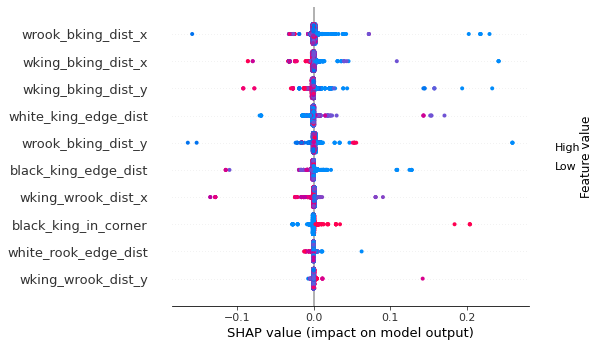

In [25]:
tmp = shap.Explanation(shap_values[:, :, 1], data=X_train, feature_names=X_train.columns)
shap.plots.beeswarm(tmp)

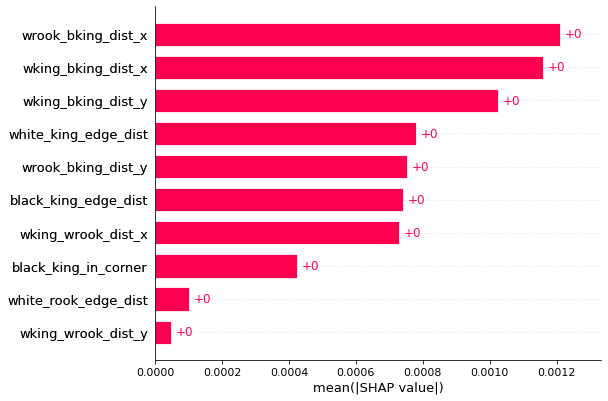

In [32]:
shap.plots.bar(tmp)

In [46]:
plot_vals = np.mean(np.abs(tmp.values), axis = 0)

In [55]:
sns.set_style("white")

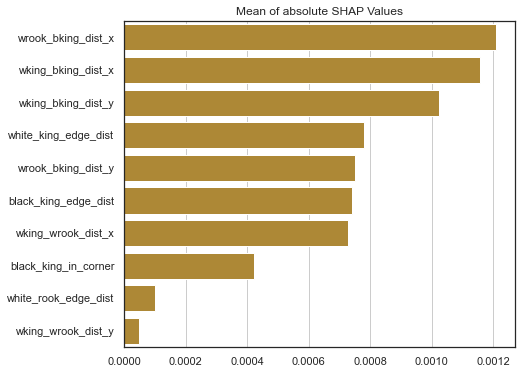

In [148]:
fig, ax = plt.subplots(figsize=(7,6))
plt.grid()
sns.barplot(ax = ax, y = X_train.columns, x = plot_vals, orient = "h",
            order=X_train.columns[plot_vals.argsort()[::-1]],
            color = "#c18f22").set(title='Mean of absolute SHAP Values')
plt.show()

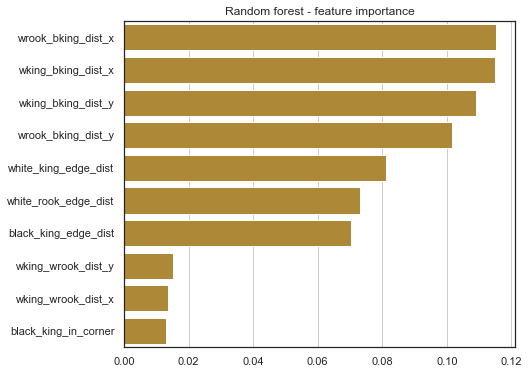

In [149]:
fig, ax = plt.subplots(figsize=(7,6))
plt.grid()
sns.barplot(ax = ax, y = X_train.columns, x = feature_importances[:-2], orient = "h",
            order=X_train.columns[feature_importances[:-2].argsort()[::-1]],
            color = "#c18f22").set(title = "Random forest - feature importance")
plt.show()

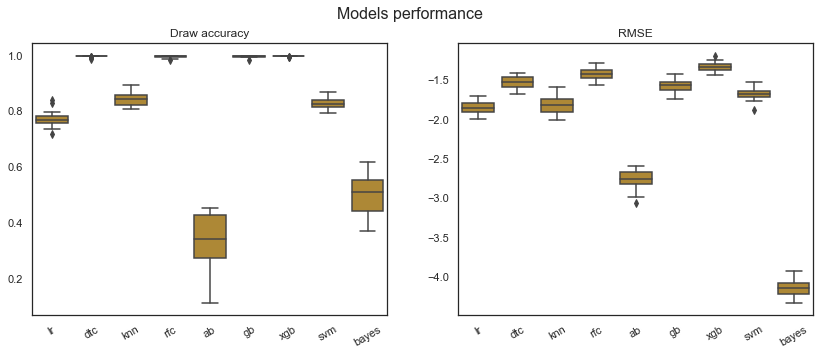

In [160]:
fig, axes = plt.subplots(1, 2, figsize = (14,5))
sns.boxplot(data = draw_results[:-1], ax = axes[0], color = "#c18f22")
axes[0].set_xticklabels(model_names[:-1], rotation = 30)
sns.boxplot(data = win_results[:-1], ax = axes[1], color = "#c18f22")
axes[1].set_xticklabels(model_names[:-1], rotation = 30)
fig.suptitle('Models performance - training data', fontsize=16)
axes[0].set_title('Draw accuracy')
axes[1].set_title('RMSE')
plt.show()

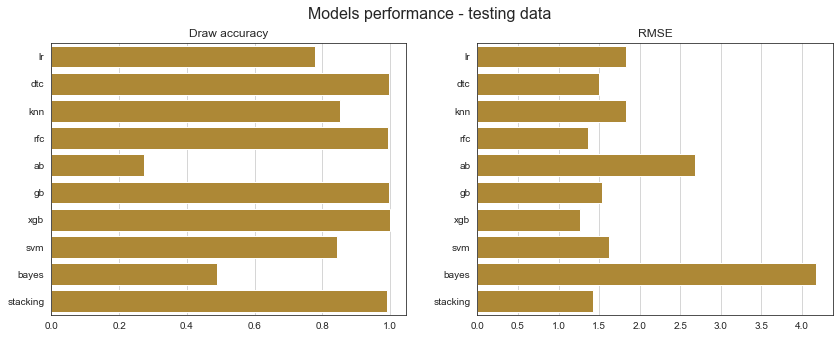

In [58]:
fig, axes = plt.subplots(1, 2, figsize = (14,5))
axes[0].grid()
axes[1].grid()
sns.barplot(x = draw_results_test, y = model_names, ax = axes[0], color = "#c18f22")
sns.barplot(x = -1 * np.array(win_results_test), y = model_names, ax = axes[1], color = "#c18f22")
fig.suptitle('Models performance - testing data', fontsize=16)
axes[0].set_title('Draw accuracy')
axes[1].set_title('RMSE')
plt.show()

## Testowanie modelu ze zwiększoną liczbą cech

In [92]:
df_train_add = pd.read_csv("train_data_add.csv", index_col = 0)
df_test_add = pd.read_csv("test_data_add.csv", index_col = 0)

In [94]:
df_train_add.head()

,white_king_file,white_king_rank,white_rook_file,white_rook_rank,black_king_file,black_king_rank,result
0,d,1,c,5,e,3,fourteen
1,d,1,g,1,a,4,thirteen
2,c,2,a,7,h,5,thirteen
3,b,1,f,5,f,2,fifteen
4,d,1,h,6,a,4,fourteen


In [105]:
X_train_add = X_train.copy()
X_train_add["white_king_file"] = df_train_add["white_king_file"].apply(lambda x: ord(x) - 96)
X_train_add["white_king_rank"] = df_train_add["white_king_rank"]
X_train_add["white_rook_file"] = df_train_add["white_rook_file"].apply(lambda x: ord(x) - 96)
X_train_add["white_rook_rank"] = df_train_add["white_rook_rank"]
X_train_add["black_king_file"] = df_train_add["black_king_file"].apply(lambda x: ord(x) - 96)
X_train_add["black_king_rank"] = df_train_add["black_king_rank"]

X_test_add = X_test.copy()
X_test_add["white_king_file"] = df_test_add["white_king_file"].apply(lambda x: ord(x) - 96)
X_test_add["white_king_rank"] = df_test_add["white_king_rank"]
X_test_add["white_rook_file"] = df_test_add["white_rook_file"].apply(lambda x: ord(x) - 96)
X_test_add["white_rook_rank"] = df_test_add["white_rook_rank"]
X_test_add["black_king_file"] = df_test_add["black_king_file"].apply(lambda x: ord(x) - 96)
X_test_add["black_king_rank"] = df_test_add["black_king_rank"]

In [101]:
tuned_stacking_add = StackingClassifier(estimators=tuned_models, final_estimator = LogisticRegression(), cv=5)
tuned_stacking_add.fit(X_train_add, y_train)

StackingClassifier(cv=5,
                   estimators=[('dtc', DecisionTreeClassifier(random_state=1)),
                               ('rfc',
                                RandomForestClassifier(bootstrap=False,
                                                       max_depth=12,
                                                       min_samples_split=5,
                                                       n_estimators=600,
                                                       random_state=1)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster='gbtree',
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              enable_categorical=False,
                                              gamma=No...
                                   

In [109]:
from sklearn.metrics import classification_report

In [106]:
draw_f1_fun(tuned_stacking_add.predict(X_test_add), y_test)

0.9977023232065356

In [108]:
win_neg_rmse_fun(tuned_stacking_add.predict(X_test_add), y_test)

-0.7051438715686124

In [113]:
print(classification_report(y_test, tuned_stacking_add.predict(X_test_add)))

              precision    recall  f1-score   support

          -1       1.00      1.00      1.00      1957
           0       1.00      0.74      0.85        19
           1       1.00      0.78      0.88        55
           2       0.95      0.92      0.93       172
           3       0.71      0.63      0.67        57
           4       0.77      0.71      0.74       139
           5       0.80      0.71      0.76       330
           6       0.70      0.72      0.71       414
           7       0.67      0.62      0.64       478
           8       0.75      0.78      0.77      1003
           9       0.75      0.71      0.73      1198
          10       0.72      0.66      0.68      1389
          11       0.70      0.76      0.73      1998
          12       0.75      0.74      0.74      2518
          13       0.77      0.80      0.78      2936
          14       0.83      0.86      0.84      3187
          15       0.85      0.83      0.84      1516
          16       0.89    

Dodanie oryginalnych zmiennych poprawiło predykcyjność. Istnieje szansa, że z dodanymi zmiennymi jakieś inne modele miały lepsze wyniki. Nie możemy tego jednak sprawdzić ze względu na ograniczenia czasowe.